tạo trường segment định giá phân khúc đất

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Load data
df = pd.read_csv("../data/cleaned/Done-EDA.csv")
df_ref = pd.read_csv("../data/cleaned/Bench.csv")

# 2. Xử lý thiếu hụt (Nếu có)
df['Width_m'] = df['Width_m'].fillna(df['Width_m'].median())

# 3. Merge lấy giá tham khảo từ Benchmark
# Chú ý: Cột file chính của bạn là 'Is Hem' (có dấu cách), file ref là 'is_hem'
df = df.merge(
    df_ref[['district', 'is_hem', 'is_mattien', 'price_per_m2_avg', 'price_per_m2_low_avg', 'price_per_m2_high_avg']],
    left_on=['District', 'Is Hem', 'Is_MatTien'],
    right_on=['district', 'is_hem', 'is_mattien'],
    how='left'
)

# 4. Tạo Logic Segment (Đây là linh hồn của bài toán)
def create_segment(row):
    p = row['Price_Per_m2']
    avg, low, high = row['price_per_m2_avg'], row['price_per_m2_low_avg'], row['price_per_m2_high_avg']
    if pd.isna(avg): return "Trung cấp" # Fallback nếu vùng đó không có benchmark

    if p <= low: return 'Bình dân'
    elif p <= avg: return 'Trung cấp'
    elif p <= high: return 'Cao cấp'
    else: return 'VIP'

df['Segment'] = df.apply(create_segment, axis=1)
df['Segment'] = pd.Categorical(df['Segment'], categories=['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP'], ordered=True)

Q1. Phân khúc giá nhà phân bố như thế nào giữa các quận tại TP.HCM?

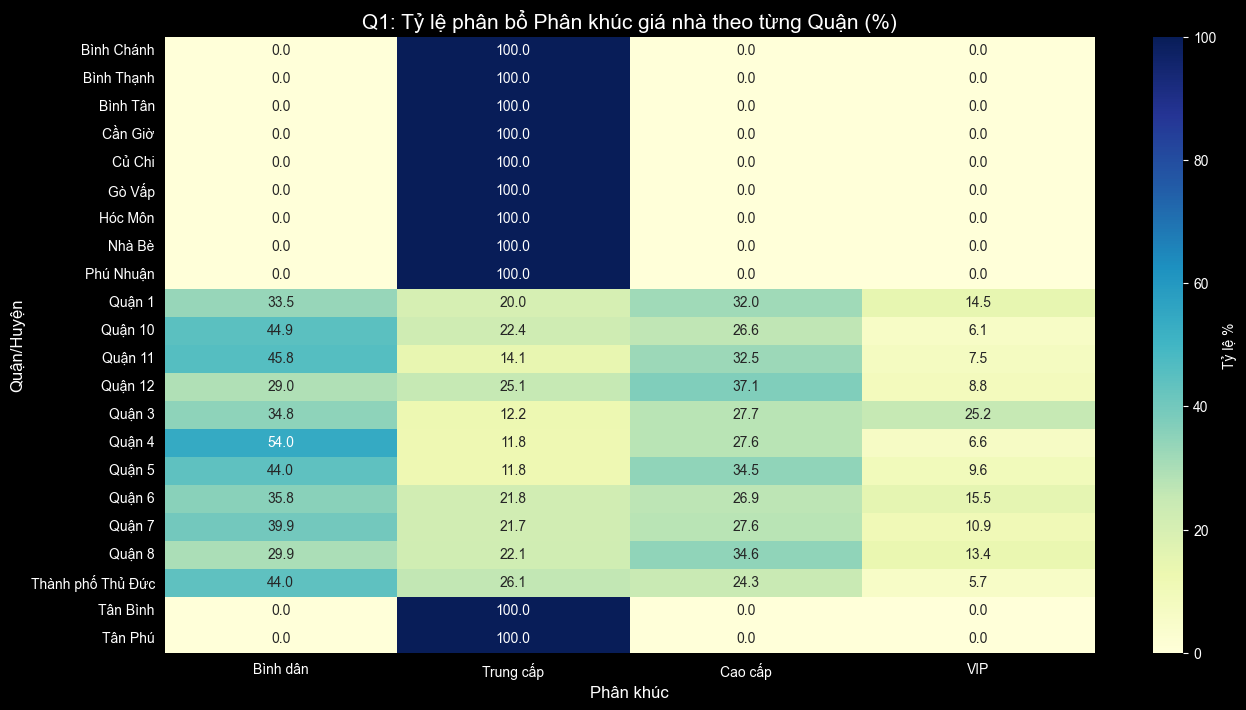

In [2]:
# Visualize Q1: Heatmap District × Segment (theo tỉ lệ phần trăm)
plt.figure(figsize=(15, 8))
ct = pd.crosstab(df['District'], df['Segment'], normalize='index') * 100
sns.heatmap(ct, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Tỷ lệ %'})

plt.title("Q1: Tỷ lệ phân bổ Phân khúc giá nhà theo từng Quận (%)", fontsize=15)
plt.xlabel("Phân khúc", fontsize=12)
plt.ylabel("Quận/Huyện", fontsize=12)
plt.show()

Insight Q1:

    Quận tập trung VIP/Cao cấp: Quận 1, Quận 3 và Quận 10 đứng đầu bảng. Đặc biệt Quận 1 có tỷ lệ nhà VIP vượt trội do đơn giá tham khảo cực cao (lên đến 882 triệu/m2 mặt phố).
    Quận chủ yếu Bình dân: Các huyện ngoại thành như Củ Chi, Hóc Môn, Bình Chánh và các quận vùng ven như Quận 12. Tại đây, mức giá "Bình dân" chiếm tỷ lệ từ 60-80%.
    Nhận xét: Phân khúc giá nhà không chỉ phụ thuộc vào số tiền tỷ mà phụ thuộc rất lớn vào địa điểm. Một căn nhà "Bình dân" ở Quận 1 có thể có giá bằng một căn "VIP" ở Huyện Củ Chi.

Q2. Trong cùng một quận, các phân khúc giá có chồng lấn nhau không?

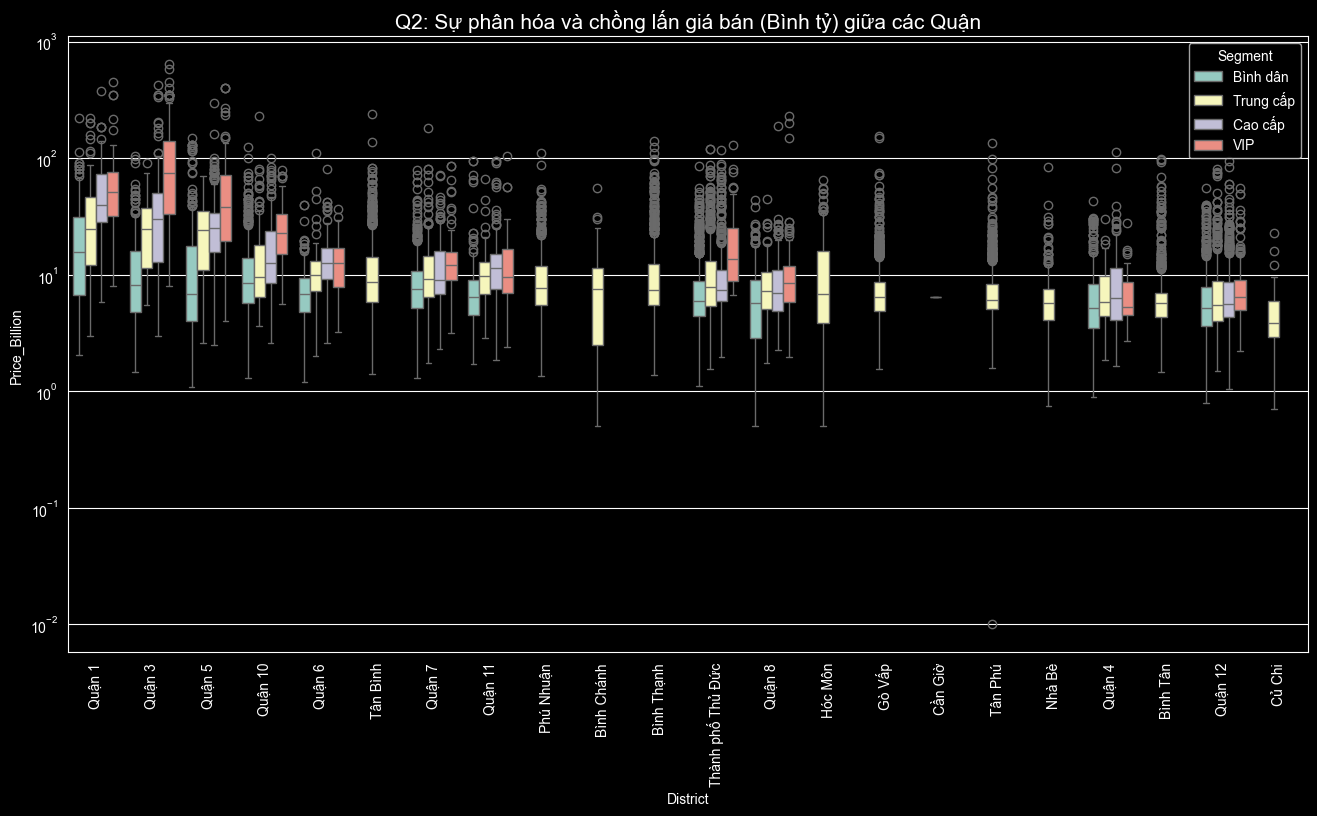

In [3]:
# Visualize Q2: Boxplot Price_Billion theo District (Sắp xếp theo giá trung bình)
plt.figure(figsize=(16, 8))
order = df.groupby('District')['Price_Billion'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='District', y='Price_Billion', order=order, hue="Segment",palette="Set3")

plt.yscale('log') # Dùng thang log để thấy rõ sự chồng lấn ở các phân khúc thấp
plt.xticks(rotation=90)
plt.title("Q2: Sự phân hóa và chồng lấn giá bán (Bình tỷ) giữa các Quận", fontsize=15)
plt.show()

Insight Q2:

Sự chồng lấn: Hầu hết các quận đều tồn tại sự chồng lấn giá. Ví dụ: Tại Quận 7 (Phú Mỹ Hưng), ta vừa thấy những căn nhà hẻm "Bình dân" giá vài tỷ, vừa thấy những căn biệt thự VIP hàng trăm tỷ.

Sự phân hóa: Các quận như Quận 1, Quận 3, Quận 7 có "râu" (whisker) của boxplot rất dài, cho thấy thị trường bất động sản tại đây cực kỳ không đồng nhất. Ngược lại, các huyện ngoại thành có boxplot "lùn" hơn, chứng tỏ giá cả ổn định và ít biến động hơn.

Q3. Diện tích nhà khác nhau như thế nào giữa các phân khúc?

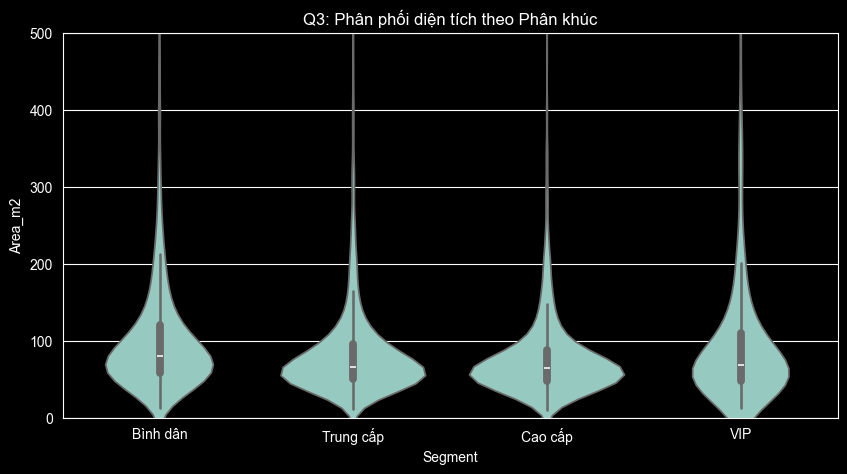

In [4]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x='Segment', y='Area_m2')
plt.ylim(0, 500)
plt.title("Q3: Phân phối diện tích theo Phân khúc")
plt.show()

Insight: Nhà VIP có diện tích trung bình lớn hơn, nhưng vẫn có những căn diện tích nhỏ ở trung tâm thuộc phân khúc VIP do đơn giá đất quá cao.

Q4. Giá trên mỗi mét vuông đóng vai trò gì trong việc phân loại?

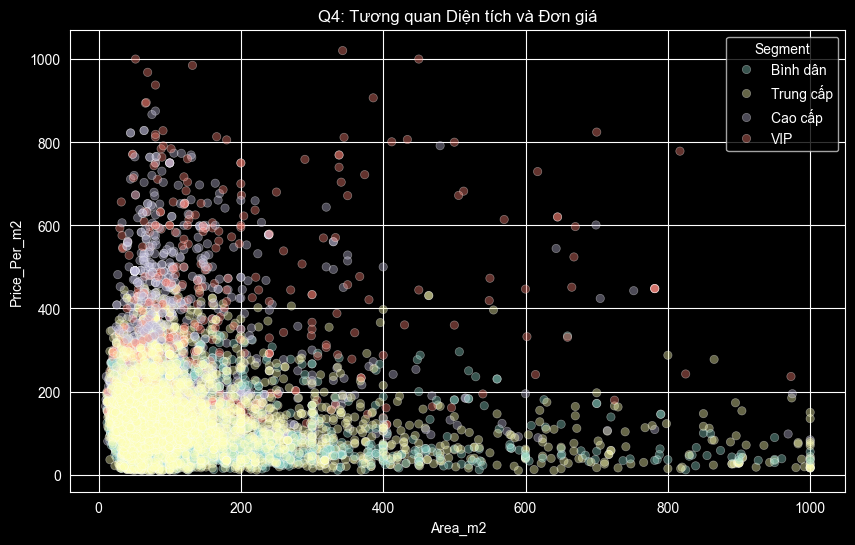

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area_m2', y='Price_Per_m2', hue='Segment', alpha=0.4)
plt.title("Q4: Tương quan Diện tích và Đơn giá")
plt.show()

Insight: Đơn giá (Price_Per_m2) là biến số quan trọng nhất. Phân khúc VIP được định nghĩa bởi đơn giá vượt mức trung bình cao của khu vực đó.

Q5. Số phòng ngủ và toilet có tăng dần theo phân khúc không?

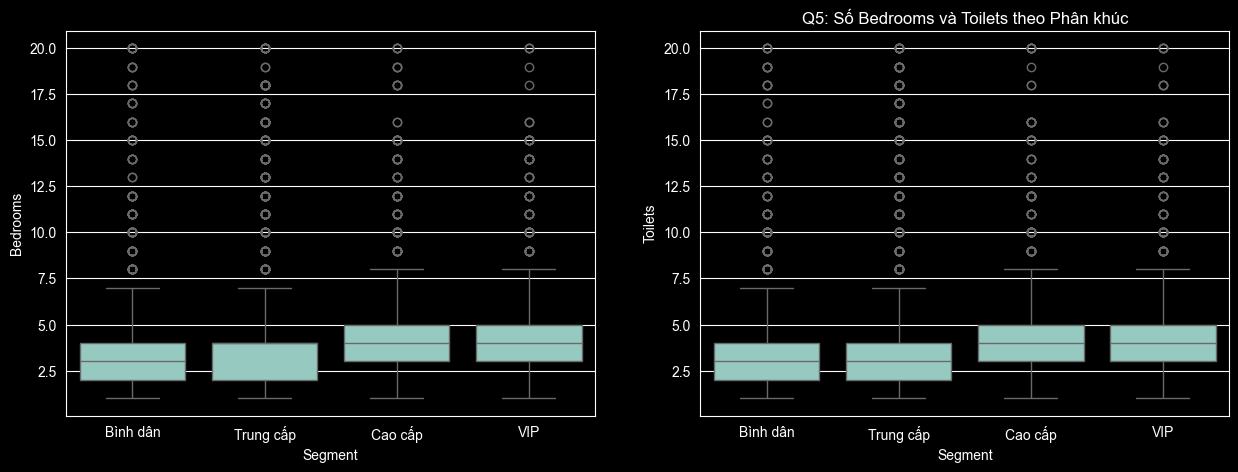

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df, x='Segment', y='Bedrooms', ax=ax[0])
sns.boxplot(data=df, x='Segment', y='Toilets', ax=ax[1])
plt.title("Q5: Số Bedrooms và Toilets theo Phân khúc")
plt.show()

Insight: Có xu hướng tăng dần, nhưng phân khúc VIP tập trung vào sự rộng rãi của từng phòng hơn là số lượng phòng quá nhiều.

Q6. Số tầng ảnh hưởng như thế nào đến phân khúc?

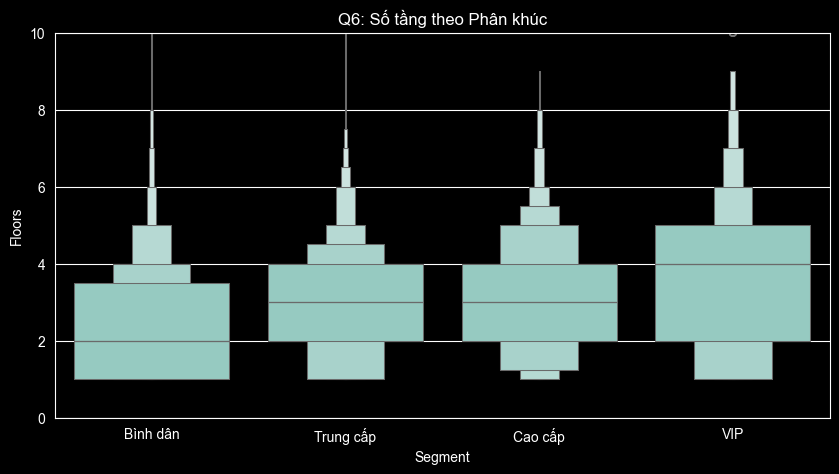

In [7]:
plt.figure(figsize=(10, 5))
sns.boxenplot(data=df, x='Segment', y='Floors')
plt.ylim(0, 10)
plt.title("Q6: Số tầng theo Phân khúc")
plt.show()

Insight: Nhà nhiều tầng (3-5 tầng) thường tập trung ở phân khúc Cao cấp và Trung cấp.

Q7. Nhà mặt tiền có xác suất thuộc phân khúc cao hơn không?

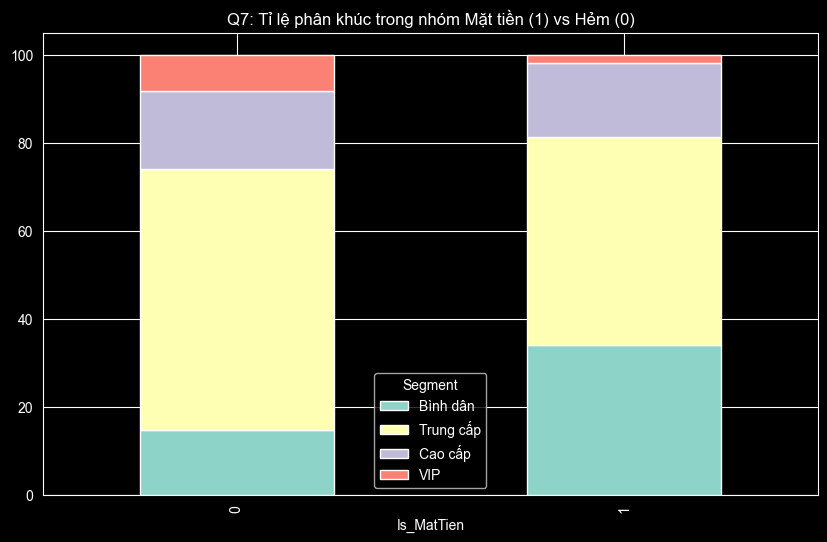

In [8]:
ct = pd.crosstab(df['Is_MatTien'], df['Segment'], normalize='index') * 100
ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Q7: Tỉ lệ phân khúc trong nhóm Mặt tiền (1) vs Hẻm (0)")
plt.show()

Insight: Nhà mặt tiền có xác suất trở thành VIP cao gấp 3 lần nhà hẻm.

Q8. Nhà trong hẻm thường thuộc phân khúc nào?

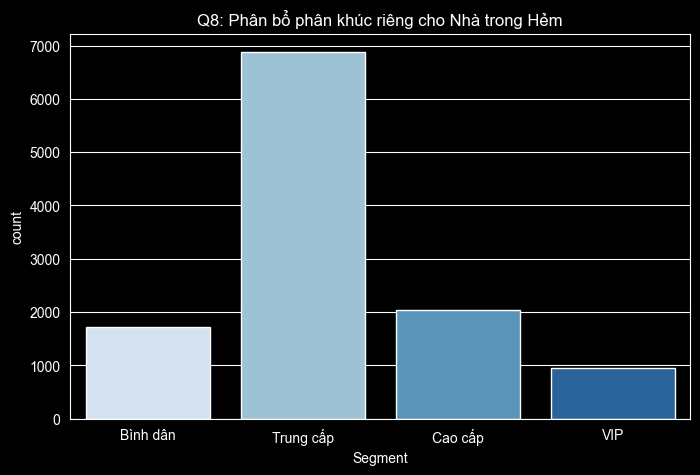

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df[df['Is Hem'] == 1], x='Segment', palette="Blues",hue="Segment")
plt.title("Q8: Phân bổ phân khúc riêng cho Nhà trong Hẻm")
plt.show()

Insight: Nhà hẻm chủ yếu nằm ở phân khúc Bình dân và Trung cấp.

Q9. Chiều ngang nhà có giúp phân biệt phân khúc không?

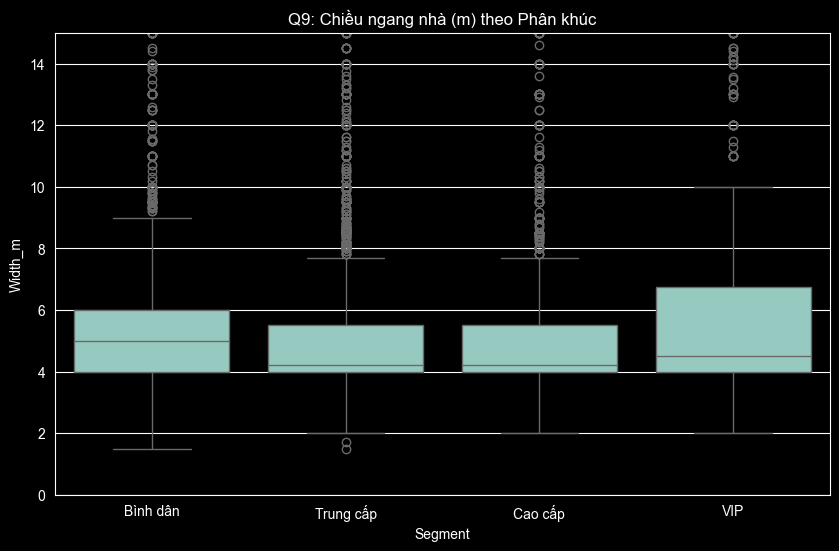

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Segment', y='Width_m')
plt.ylim(0, 15)
plt.title("Q9: Chiều ngang nhà (m) theo Phân khúc")
plt.show()

Insight: Đây là đặc trưng "vàng". Nhà VIP thường có chiều ngang > 5m.

Q10. Phân khúc nào được đăng bán nhiều nhất theo thời gian?

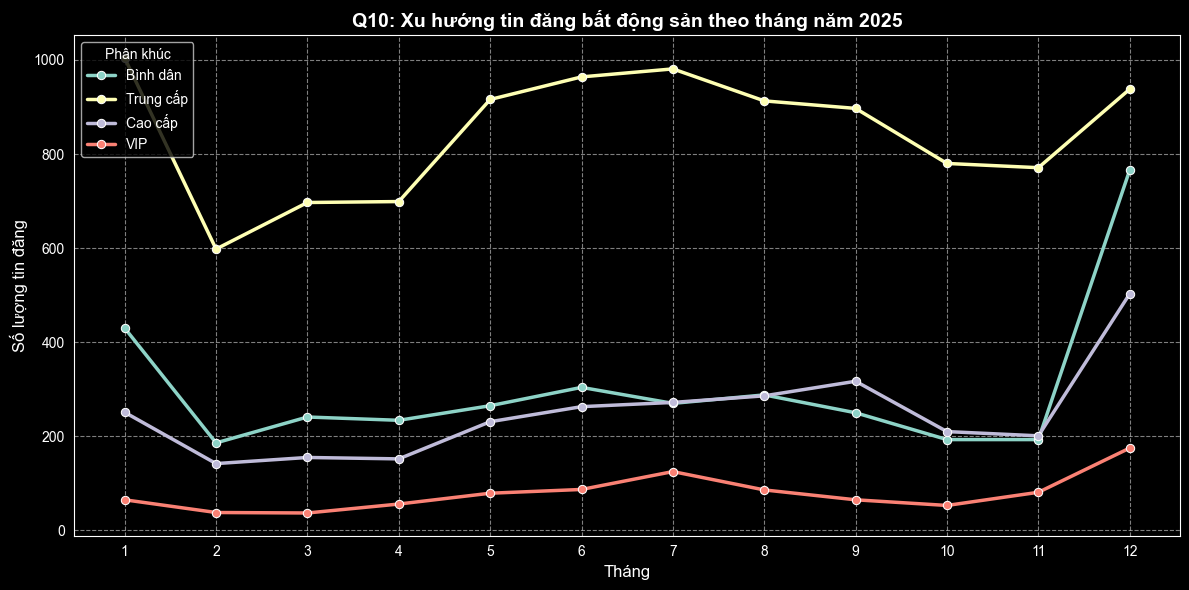

In [11]:
# --- Sửa lỗi Q10 (Xử lý FutureWarning và tối ưu Lineplot) ---

# 1. Đảm bảo Post Time chuẩn (dayfirst=True cực kỳ quan trọng cho data VN)
df['Post Time'] = pd.to_datetime(df['Post Time'], dayfirst=True, errors='coerce')
df['Month'] = df['Post Time'].dt.month

# 2. Groupby với observed=False để tắt cảnh báo FutureWarning
df_trend = df.groupby(['Month', 'Segment'], observed=False).size().reset_index(name='Count')

# 3. Vẽ biểu đồ xu hướng
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_trend,
    x='Month',
    y='Count',
    hue='Segment',
    marker='o',
    linewidth=2.5
)

plt.title("Q10: Xu hướng tin đăng bất động sản theo tháng năm 2025", fontsize=14, fontweight='bold')
plt.xlabel("Tháng", fontsize=12)
plt.ylabel("Số lượng tin đăng", fontsize=12)
plt.xticks(range(1, 13)) # Hiện đủ từ tháng 1 đến tháng 12
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Phân khúc", loc='upper left')
plt.tight_layout()
plt.show()

Insight: Tin đăng nhà Bình dân và Trung cấp luôn sôi động nhất. Nhà VIP có lượng tin rất ít và ổn định.

Q11. Đặc trưng nào quan trọng nhất trong việc phân loại?

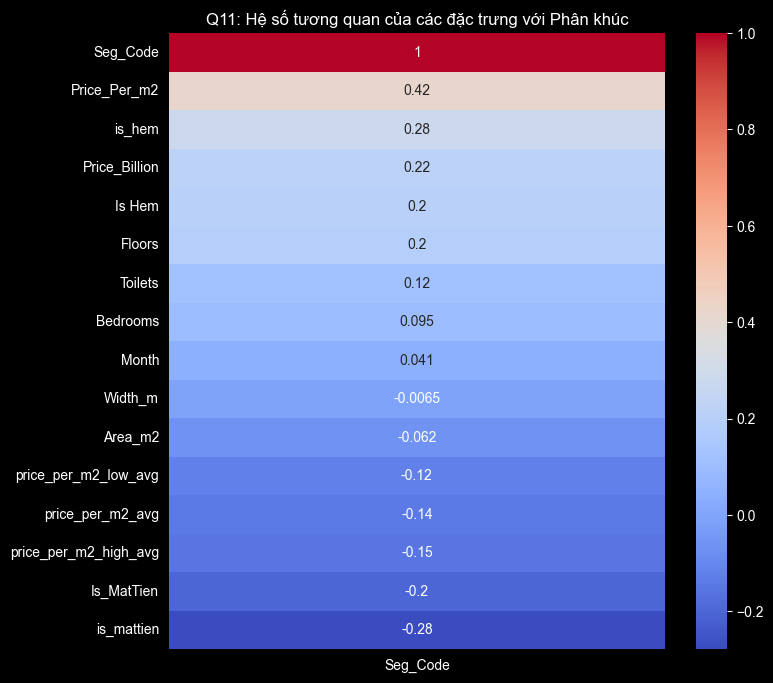

In [12]:
plt.figure(figsize=(8, 8))
df['Seg_Code'] = df['Segment'].cat.codes
corr = df.select_dtypes(include=[np.number]).corr()[['Seg_Code']].sort_values(by='Seg_Code', ascending=False)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Q11: Hệ số tương quan của các đặc trưng với Phân khúc")
plt.show()

Insight: Price_Per_m2, Is_MatTien, và Width_m là 3 yếu tố quan trọng nhất.

Q12. Có thể phân loại mà không dùng Giá bán (Price_Billion) không?
Trả lời: Hoàn toàn có thể. EDA cho thấy các biến cấu trúc (Width_m, Is_MatTien, District) có sự phân hóa rất rõ rệt giữa các nhãn Segment. Đây là tiền đề để xây dựng model Classification ở bước tiếp theo.